In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'].split(',')

['0']

In [2]:
DEVICE = 'cuda:0'

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import numpy as np
import torch
from typing import Optional
from scipy.optimize import linear_sum_assignment


def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [5]:
def lp_distance(X, Y, p=2):
    """
    Computes row wise minkowski distances between matrices X and Y
    """
    return torch.sum(torch.abs(X-Y)**p, dim=1)**(1/p)

In [6]:
from transformers import PreTrainedTokenizer
from typing import *

def mask_tokens(inputs: torch.Tensor, tokenizer) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
    """

    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, 0.15)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [7]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        
        self.texts = texts
        self.labels = labels


        self.labels = torch.tensor(self.labels, dtype=torch.float)
        
    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

    
    def __len__(self):
        return len(self.texts)

In [8]:
# 20 newsgroups
#from sklearn.datasets import fetch_20newsgroups
#data = fetch_20newsgroups(
#    categories=['comp.graphics', 'talk.religion.misc', 'rec.autos', 'misc.forsale'],
#    remove=('headers', 'footers', 'quotes'),
#    shuffle=True,
#    random_state=42
#)
#texts, labels = data.data, data.target

In [9]:
#plt.bar(*np.unique(labels, return_counts=True))

In [10]:
#import tensorflow_datasets as tfds
#from itertools import chain
#
#train_ds = tfds.load('ag_news_subset', split='train', shuffle_files=True)
#test_ds = tfds.load('ag_news_subset', split='test', shuffle_files=True)
#
#texts, labels = [], []
#
#for ds in (train_ds, test_ds):
#    for example in tfds.as_numpy(ds):
#        text, label = example['description'], example['label']
#        texts.append(text.decode("utf-8"))
#        labels.append(label)
#
#labels = np.array(labels)
#
#del train_ds
#del test_ds

In [11]:
#from sklearn.model_selection import train_test_split
#
#texts, _, labels, _ = train_test_split(texts, labels, test_size=0.995, random_state=42)
#len(texts), len(labels)

In [12]:
#import pandas as pd
#
#save = pd.DataFrame()
#save['texts'] = texts
#save['labels'] = labels
#save.to_csv('temp.csv')

In [13]:
import pandas as pd
df = pd.read_csv('ag_news_995.csv')

texts = df['texts'].to_numpy()
labels = df['labels'].to_numpy()

del df

In [14]:
data = TextDataset(texts, labels)
data_loader = DataLoader(dataset=data, batch_size=4, shuffle=False)

In [15]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
from transformers import ElectraTokenizer, ElectraForMaskedLM
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertForMaskedLM
from transformers import RobertaTokenizer, RobertaForMaskedLM
from transformers import XLNetTokenizer, XLNetLMHeadModel

import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased', return_dict=True)

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', return_dict=True)
#lm_model = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)

#tokenizer = RobertaTokenizer.from_pretrained('roberta-base', return_dict=True)
#lm_model = RobertaForMaskedLM.from_pretrained('roberta-base', return_dict=True)

#tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator', return_dict=True)
#lm_model = ElectraForMaskedLM.from_pretrained('google/electra-base-discriminator', return_dict=True)

#tokenizer = AutoTokenizer.from_pretrained("distilroberta-base", return_dict=True)
#lm_model = AutoModelForMaskedLM.from_pretrained("distilroberta-base", return_dict=True)


#tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased", return_dict=True)
#lm_model = XLNetLMHeadModel.from_pretrained("xlnet-base-cased", return_dict=True, mem_len=1024)


lm_model.to(DEVICE)

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [16]:
from tqdm import tqdm
from sklearn.utils import resample
embeddings = []
for index, text in enumerate(tqdm(texts)):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = inputs.to(DEVICE)
    outputs = lm_model.base_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:].flatten().cpu().detach().numpy()
    #cls_embedding = outputs.last_hidden_state[:,1:,:].mean(dim=1).flatten().cpu().detach().numpy()
    
    embeddings.append(cls_embedding)

embeddings = np.array(embeddings)

100%|██████████| 638/638 [00:04<00:00, 145.65it/s]


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score


tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
Xtfidf = tfidf.fit_transform(texts)

kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)
kmeans_cluster_tfidf = kmeans.fit_predict(Xtfidf)


print(cluster_accuracy(labels, kmeans_cluster_tfidf)[1])
print(normalized_mutual_info_score(labels, kmeans_cluster_tfidf))
print(adjusted_rand_score(labels, kmeans_cluster_tfidf))
print(silhouette_score(Xtfidf, kmeans_cluster_tfidf, metric="cosine"))

0.36990595611285265
0.06188441799021127
0.02976095876585275
0.009866660737539685


In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

sbert_embeddings = sbert_model.encode(texts)

kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)
kmeans_cluster_sbert = kmeans.fit_predict(sbert_embeddings)

print(cluster_accuracy(labels, kmeans_cluster_sbert)[1])
print(normalized_mutual_info_score(labels, kmeans_cluster_sbert))
print(adjusted_rand_score(labels, kmeans_cluster_sbert))
print(silhouette_score(sbert_embeddings, kmeans_cluster_sbert, metric="cosine"))

0.6050156739811913
0.24745233747779377
0.2276224954008532
0.1003798


In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)

kmeans_cluster = kmeans.fit_predict(embeddings)
kmean_centroids = torch.from_numpy(kmeans.cluster_centers_)
kmean_centroids = kmean_centroids.to(DEVICE)

In [20]:
from umap import UMAP

umap = UMAP(n_components=2)
embeddings_plot = umap.fit_transform(embeddings)

/home/keller/.conda/envs/cuda/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10006. The TBB threading layer is disabled.
  warnings.warn(problem)


In [21]:
import plotly.express as px
fig = px.scatter(x=embeddings_plot[:, 0], y=embeddings_plot[:, 1], color=[f'{i}' for i in kmeans_cluster])
fig.show()

In [22]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score

print(cluster_accuracy(labels, kmeans_cluster)[1])
print(normalized_mutual_info_score(labels, kmeans_cluster))
print(adjusted_rand_score(labels, kmeans_cluster))
print(silhouette_score(embeddings, kmeans_cluster, metric="cosine"))

0.5815047021943573
0.36469594206419054
0.28336910131393495
0.13507245


In [23]:
#import random
#random.seed(42)
#initial_centroids = np.array([embeddings[i] for i in (random.randint(0, embeddings.shape[0]-1) for _ in range(np.unique(labels).shape[0]))])
#initial_centroids = torch.from_numpy(initial_centroids).to(DEVICE)
#initial_centroids

In [24]:
from sklearn.cluster.k_means_ import _k_init
from sklearn.utils.extmath import row_norms

# Using KMeans++ initialization
initial_centroids = _k_init(
    embeddings,
    n_clusters=np.unique(labels).shape[0],
    #n_clusters=20,
    x_squared_norms=row_norms(embeddings, squared=True),  #aka np.linalg.norm(embeddings, axis=1)**2
    random_state=np.random.RandomState(42))
initial_centroids = torch.from_numpy(initial_centroids).to(DEVICE)
initial_centroids

/home/keller/.conda/envs/cuda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.



tensor([[-0.2466, -0.2599,  0.1819,  ..., -0.2952,  0.5414,  0.3699],
        [-0.0698, -0.2036,  0.0556,  ...,  0.0086,  0.3377,  0.3447],
        [-0.5255, -0.2995,  0.0463,  ...,  0.0292,  0.4412,  0.2443],
        [-0.3697, -0.3623, -0.1220,  ..., -0.1805,  0.4613,  0.1605]],
       device='cuda:0')

In [25]:
centroids = initial_centroids.clone().to(DEVICE).requires_grad_(True)
#centroids = torch.Tensor(4, 768).uniform_(-10, 10).to(torch.float64).to(DEVICE).requires_grad_(True)
#centroids = kmean_centroids.clone().to(DEVICE).requires_grad_(True)  # go this way (cluster hardening)

Epoch 0 (Alpha -0.42320861065570825) | Batch: 159 | Combined Loss: 4.051682472229004 | Clustering Loss: 7.1881914138793945 | LM Loss 3.8719775676727295 | Accuracy 0.5: : 160it [00:13, 12.26it/s] 


Cluster Accuarcy 0.64576802507837


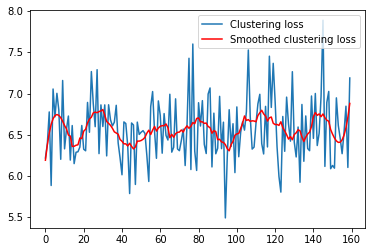

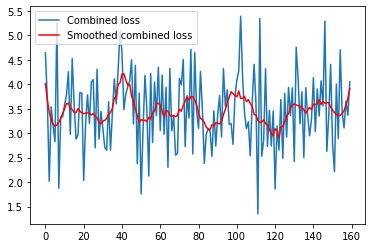

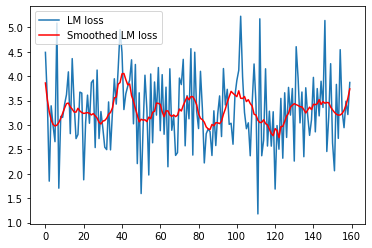

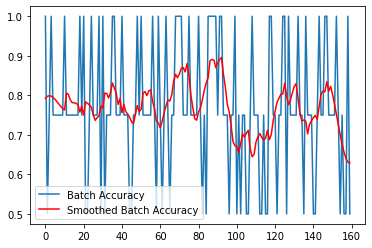

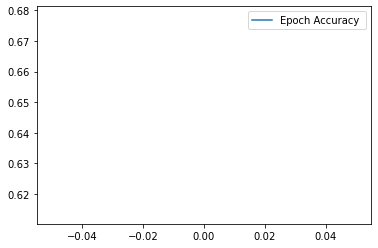

Epoch 1 (Alpha -1.7910552813313483) | Batch: 159 | Combined Loss: 3.339118480682373 | Clustering Loss: 7.062379837036133 | LM Loss 3.1625590324401855 | Accuracy 1.0: : 160it [00:13, 12.14it/s]  


Cluster Accuarcy 0.6567398119122257


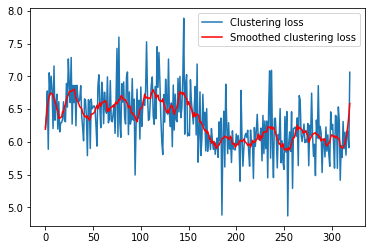

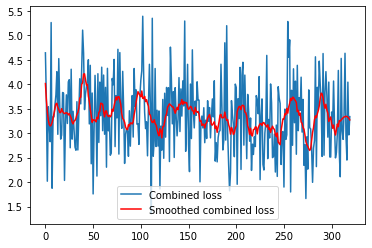

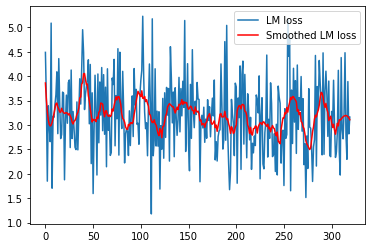

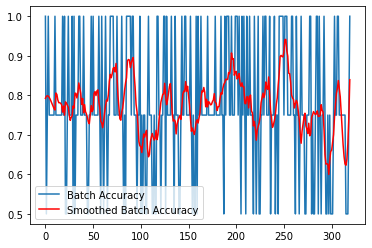

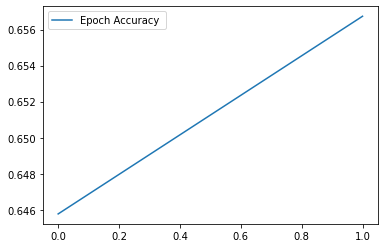

Epoch 2 (Alpha -3.180702230869025) | Batch: 159 | Combined Loss: 2.406869888305664 | Clustering Loss: 6.516366004943848 | LM Loss 2.2439606189727783 | Accuracy 1.0: : 160it [00:13, 12.19it/s]   


Cluster Accuarcy 0.6504702194357367


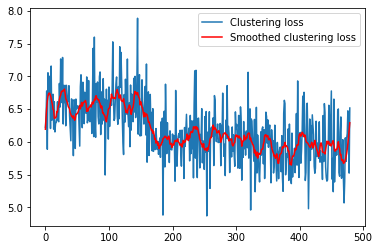

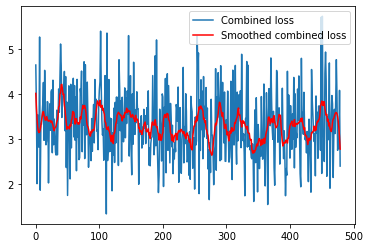

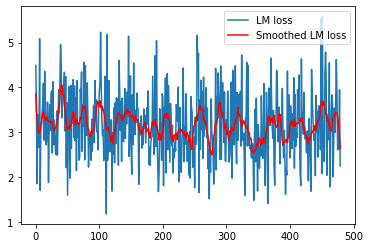

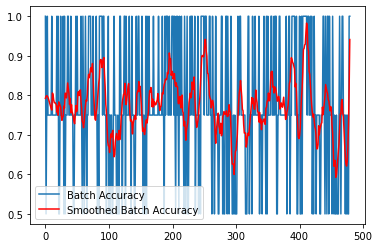

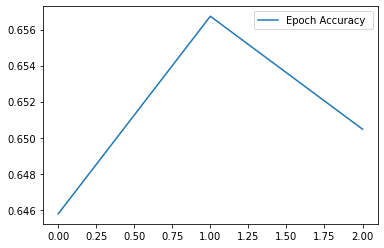

Epoch 3 (Alpha -4.562066770334265) | Batch: 159 | Combined Loss: 1.4947582483291626 | Clustering Loss: 6.343544006347656 | LM Loss 1.3361696004867554 | Accuracy 1.0: : 160it [00:13, 12.28it/s] 


Cluster Accuarcy 0.6489028213166145


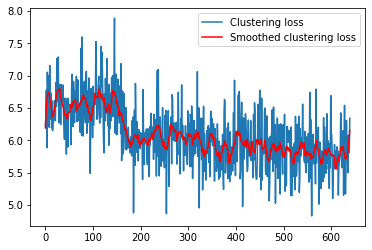

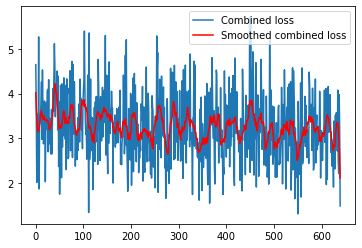

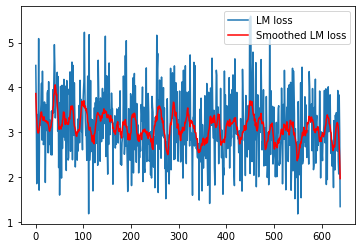

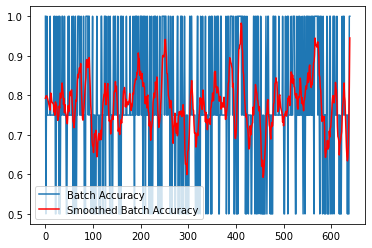

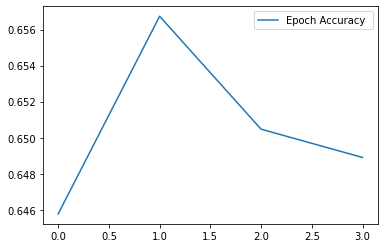

Epoch 4 (Alpha -5.961786300255737) | Batch: 159 | Combined Loss: 1.9116928577423096 | Clustering Loss: 6.122823715209961 | LM Loss 1.7586222887039185 | Accuracy 1.0: : 160it [00:13, 12.22it/s]  


Cluster Accuarcy 0.6692789968652038


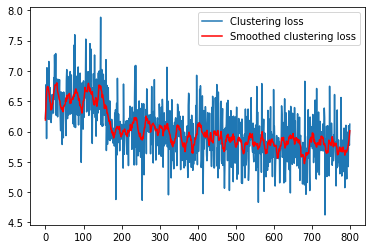

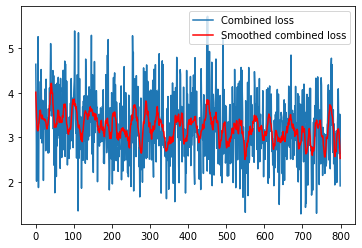

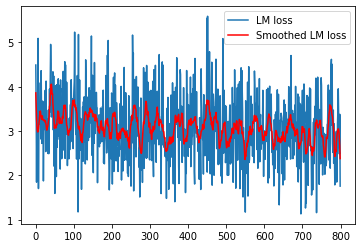

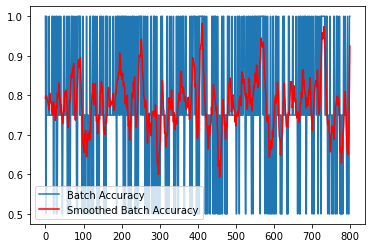

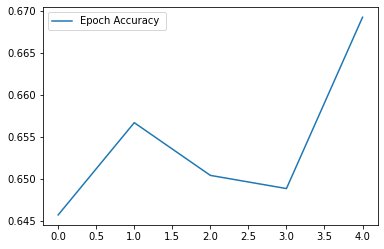

Epoch 5 (Alpha -7.398496571891645) | Batch: 159 | Combined Loss: 1.117499828338623 | Clustering Loss: 6.139411449432373 | LM Loss 0.9640145301818848 | Accuracy 1.0: : 160it [00:13, 12.09it/s]   


Cluster Accuarcy 0.6551724137931034


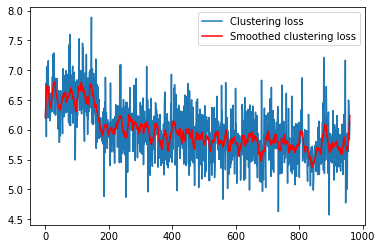

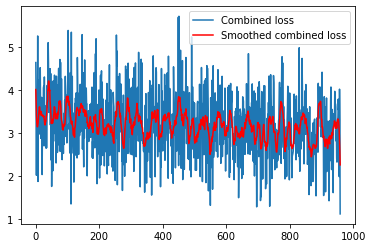

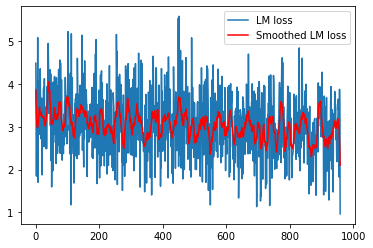

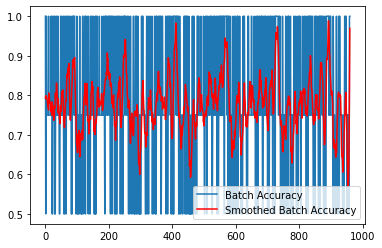

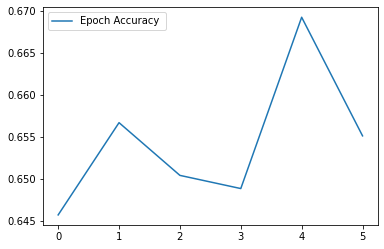

Epoch 6 (Alpha -8.884703556893125) | Batch: 159 | Combined Loss: 3.54599666595459 | Clustering Loss: 6.282250881195068 | LM Loss 3.3889403343200684 | Accuracy 1.0: : 160it [00:12, 12.37it/s]    


Cluster Accuarcy 0.6614420062695925


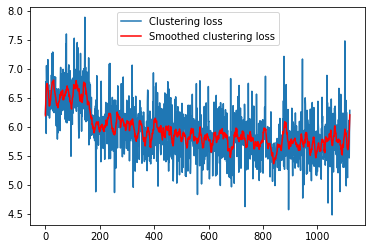

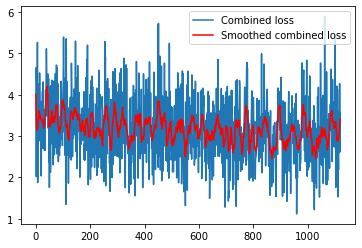

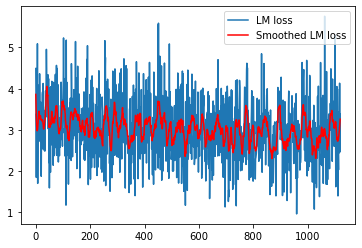

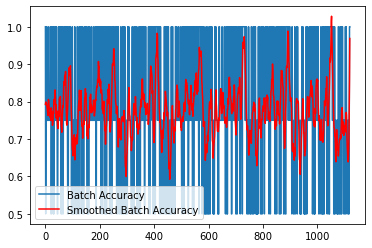

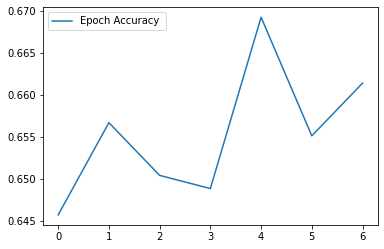

Epoch 7 (Alpha -10.429418820906777) | Batch: 159 | Combined Loss: 2.3952364921569824 | Clustering Loss: 6.144381523132324 | LM Loss 2.2416269779205322 | Accuracy 1.0: : 160it [00:13, 12.02it/s] 


Cluster Accuarcy 0.6551724137931034


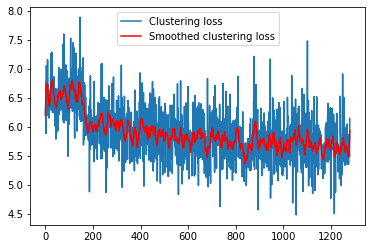

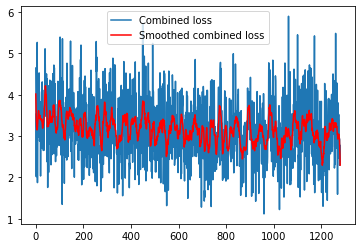

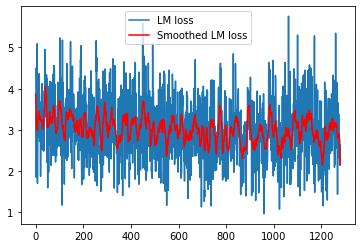

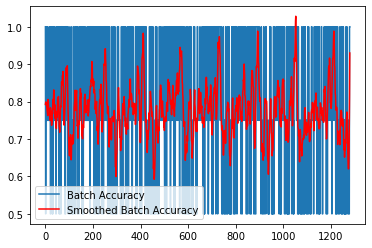

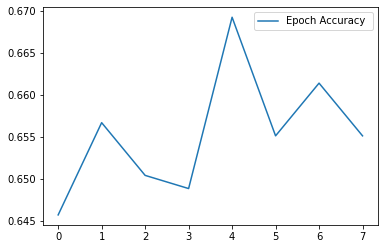

Epoch 8 (Alpha -12.039643120993707) | Batch: 159 | Combined Loss: 4.3860697746276855 | Clustering Loss: 6.896034240722656 | LM Loss 4.2136688232421875 | Accuracy 1.0: : 160it [00:12, 12.40it/s]  


Cluster Accuarcy 0.6661442006269592


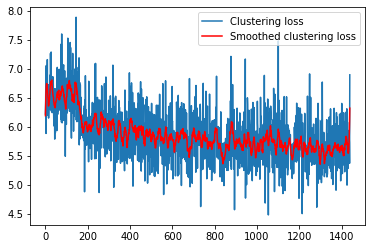

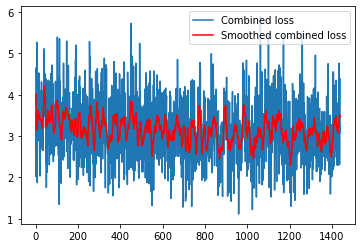

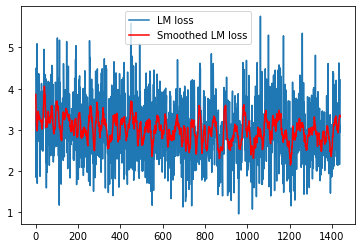

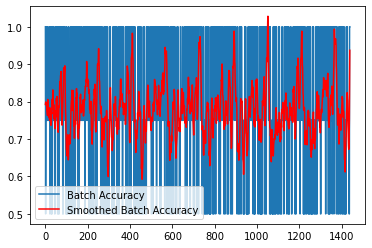

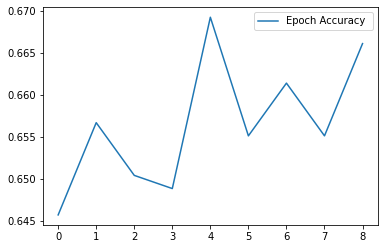

Epoch 9 (Alpha -13.721177803263439) | Batch: 159 | Combined Loss: 2.3435895442962646 | Clustering Loss: 5.893036842346191 | LM Loss 2.196263551712036 | Accuracy 1.0: : 160it [00:13, 12.15it/s]   


Cluster Accuarcy 0.6677115987460815


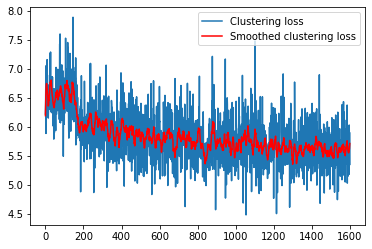

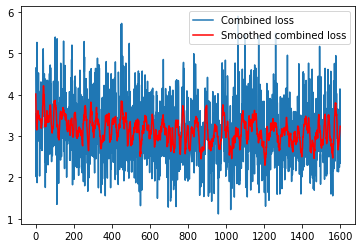

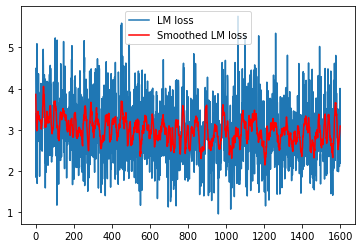

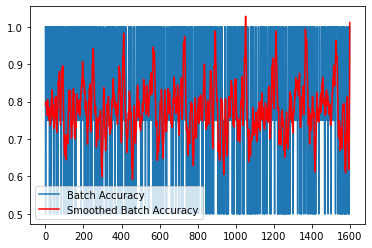

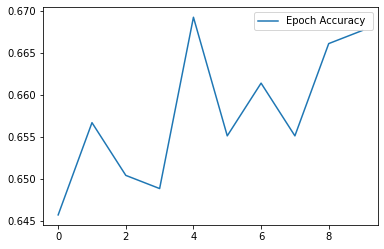

Epoch 10 (Alpha -15.479086582591446) | Batch: 159 | Combined Loss: 2.736466646194458 | Clustering Loss: 6.266093730926514 | LM Loss 2.5798141956329346 | Accuracy 1.0: : 160it [00:12, 12.35it/s]  


Cluster Accuarcy 0.6410658307210031


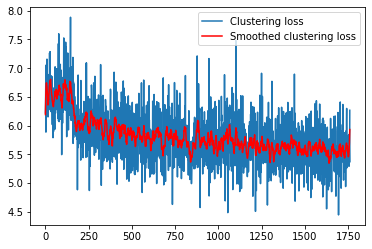

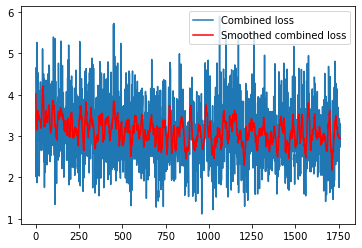

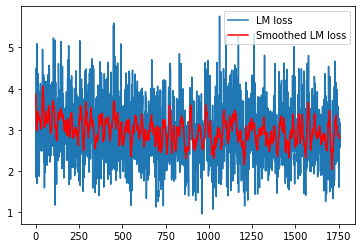

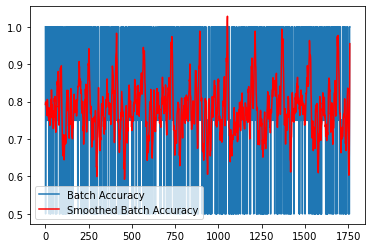

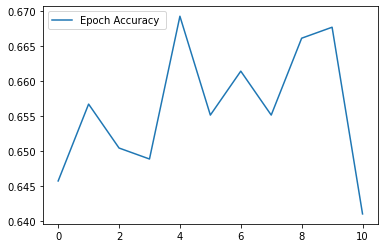

Epoch 11 (Alpha -17.31797118921001) | Batch: 159 | Combined Loss: 3.59106183052063 | Clustering Loss: 6.530855178833008 | LM Loss 3.427790403366089 | Accuracy 0.5: : 160it [00:13, 12.14it/s]     


Cluster Accuarcy 0.6692789968652038


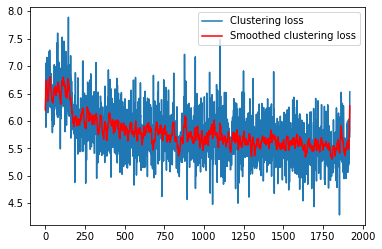

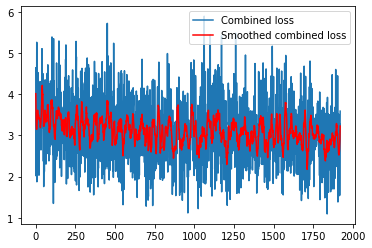

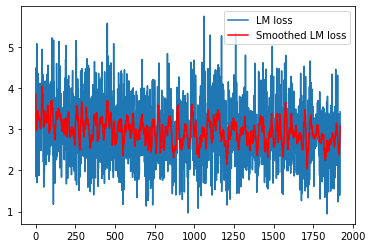

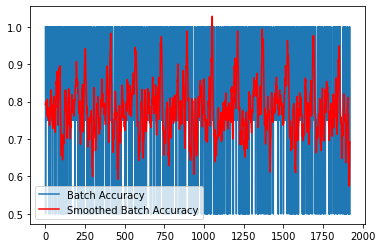

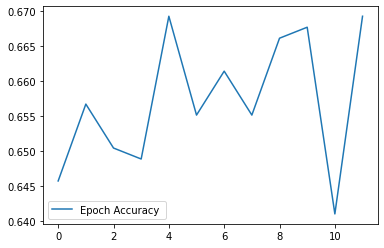

Epoch 12 (Alpha -19.242143454137818) | Batch: 159 | Combined Loss: 3.6541223526000977 | Clustering Loss: 6.40098762512207 | LM Loss 3.4940977096557617 | Accuracy 1.0: : 160it [00:13, 12.28it/s]  


Cluster Accuarcy 0.6630094043887147


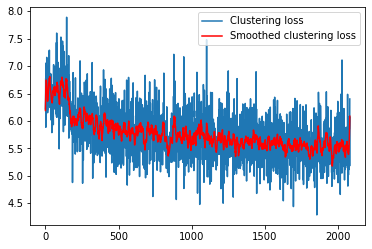

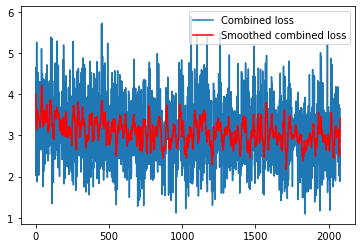

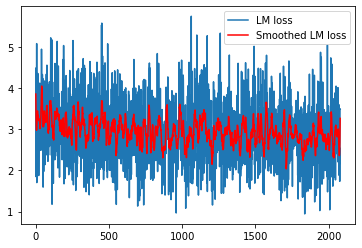

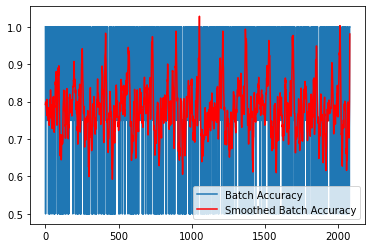

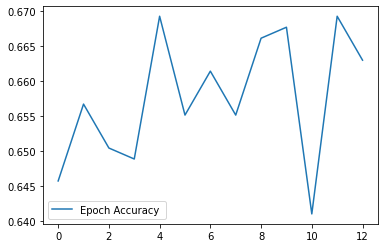

Epoch 13 (Alpha -21.25573715419616) | Batch: 159 | Combined Loss: 2.648080825805664 | Clustering Loss: 6.244132041931152 | LM Loss 2.4919774532318115 | Accuracy 1.0: : 160it [00:12, 12.62it/s]  


Cluster Accuarcy 0.6551724137931034


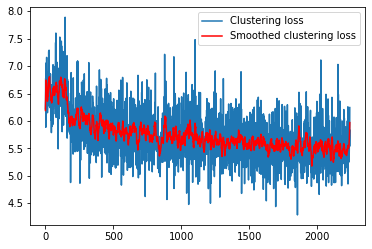

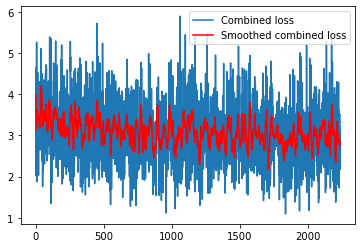

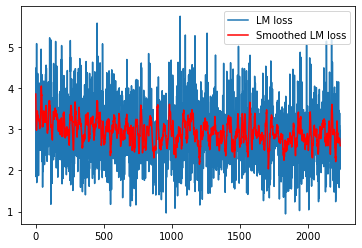

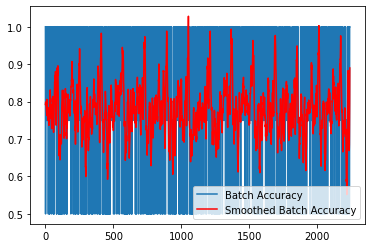

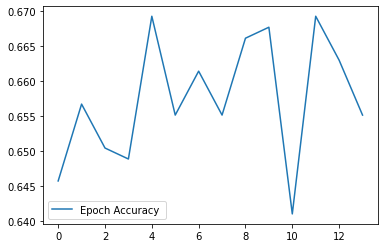

Epoch 14 (Alpha -23.362783370855293) | Batch: 159 | Combined Loss: 2.9364407062530518 | Clustering Loss: 6.004604339599609 | LM Loss 2.786325693130493 | Accuracy 1.0: : 160it [00:11, 14.27it/s]     


Cluster Accuarcy 0.6536050156739812


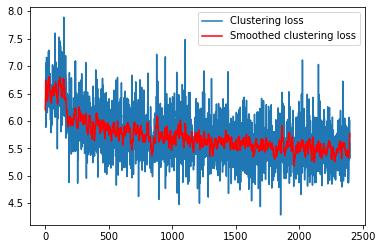

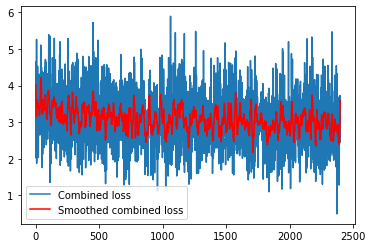

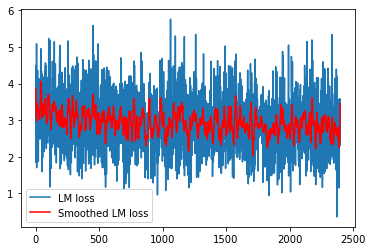

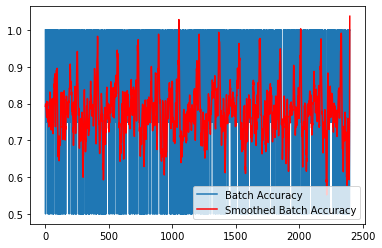

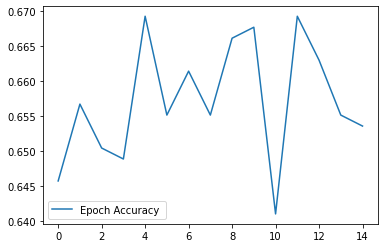

Epoch 15 (Alpha -25.56726294867969) | Batch: 159 | Combined Loss: 1.3278065919876099 | Clustering Loss: 5.896240711212158 | LM Loss 1.1804006099700928 | Accuracy 0.5: : 160it [00:11, 13.94it/s] 


Cluster Accuarcy 0.6536050156739812


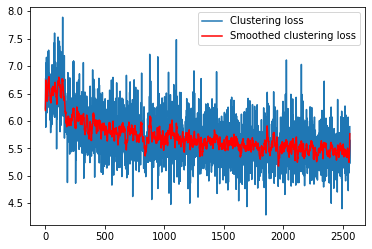

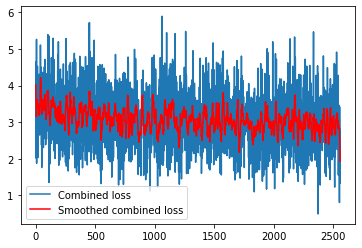

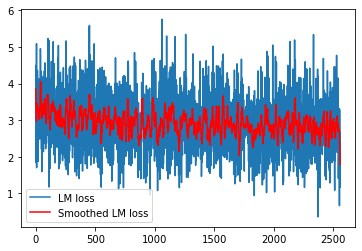

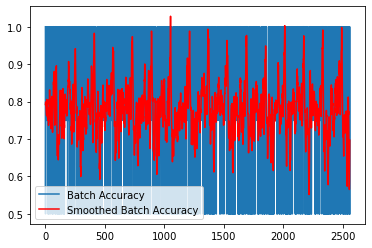

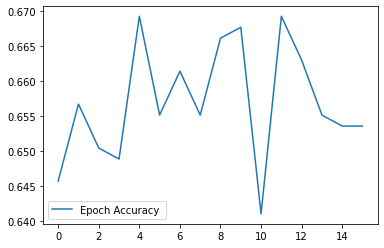

Epoch 16 (Alpha -27.87314412573138) | Batch: 159 | Combined Loss: 2.5093131065368652 | Clustering Loss: 5.942187309265137 | LM Loss 2.3607585430145264 | Accuracy 1.0: : 160it [00:10, 15.30it/s] 


Cluster Accuarcy 0.664576802507837


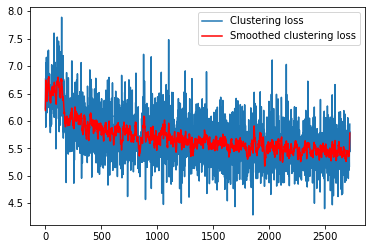

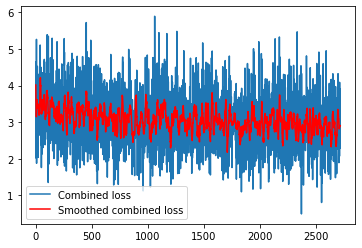

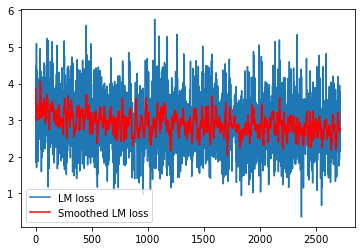

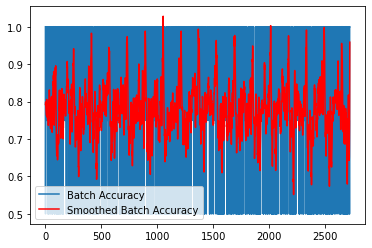

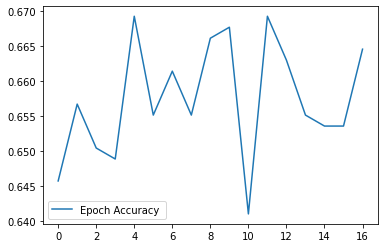

Epoch 17 (Alpha -30.284410298336294) | Batch: 159 | Combined Loss: 2.4971272945404053 | Clustering Loss: 5.96778678894043 | LM Loss 2.3479325771331787 | Accuracy 1.0: : 160it [00:10, 15.21it/s]  


Cluster Accuarcy 0.6504702194357367


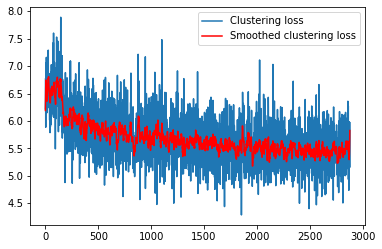

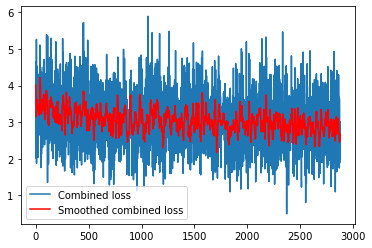

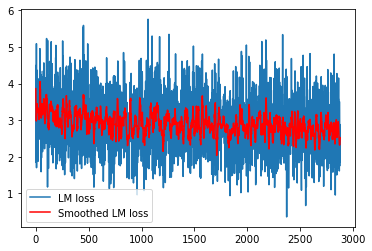

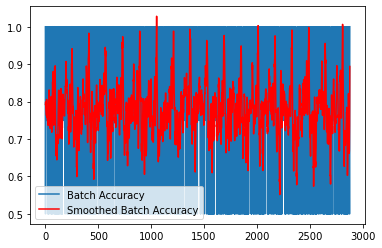

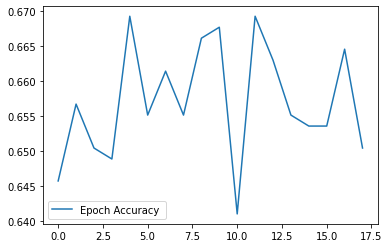

Epoch 18 (Alpha -32.805081064429196) | Batch: 159 | Combined Loss: 2.3360257148742676 | Clustering Loss: 5.627410888671875 | LM Loss 2.195340394973755 | Accuracy 1.0: : 160it [00:10, 15.10it/s]  


Cluster Accuarcy 0.6818181818181818


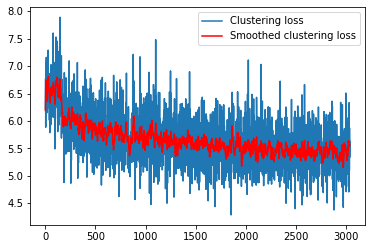

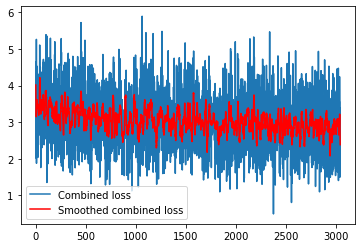

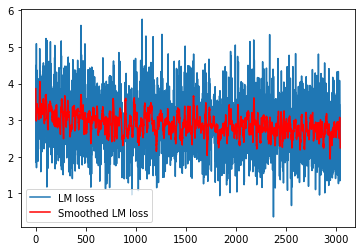

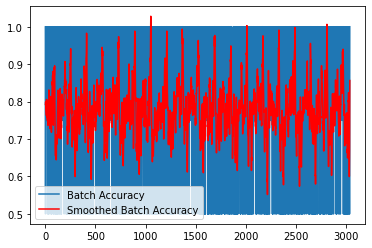

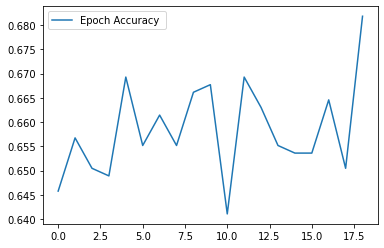

Epoch 19 (Alpha -35.439228591999786) | Batch: 159 | Combined Loss: 5.075578689575195 | Clustering Loss: 6.191227436065674 | LM Loss 4.920797824859619 | Accuracy 0.5: : 160it [00:10, 15.28it/s]    


Cluster Accuarcy 0.6473354231974922


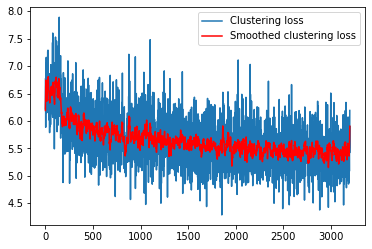

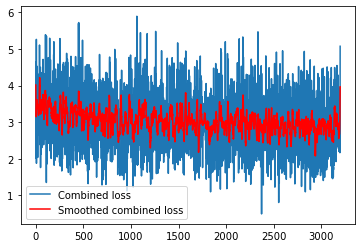

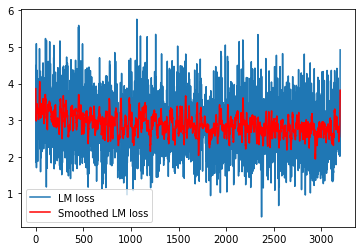

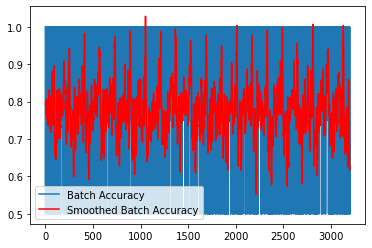

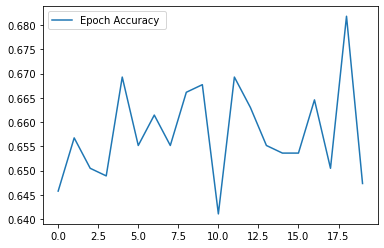

Epoch 20 (Alpha -38.19099067709667) | Batch: 159 | Combined Loss: 4.933975696563721 | Clustering Loss: 6.163161277770996 | LM Loss 4.7798967361450195 | Accuracy 1.0: : 160it [00:10, 15.24it/s]  


Cluster Accuarcy 0.6677115987460815


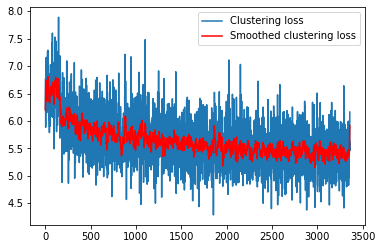

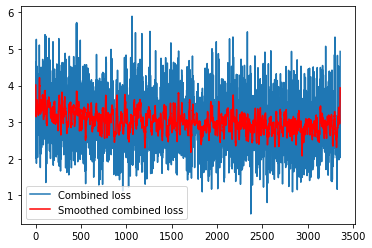

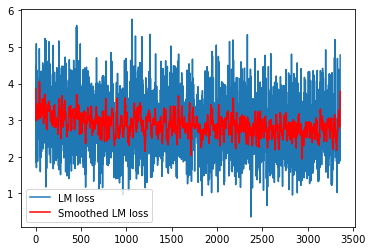

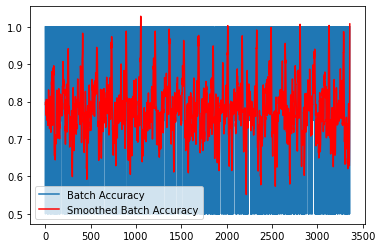

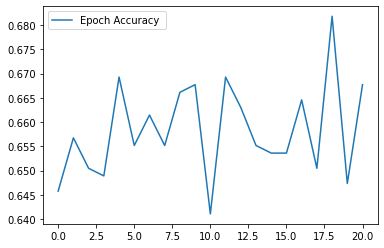

Epoch 21 (Alpha -41.06458142094335) | Batch: 159 | Combined Loss: 2.076702833175659 | Clustering Loss: 5.882722854614258 | LM Loss 1.9296348094940186 | Accuracy 1.0: : 160it [00:10, 15.33it/s]  


Cluster Accuarcy 0.6802507836990596


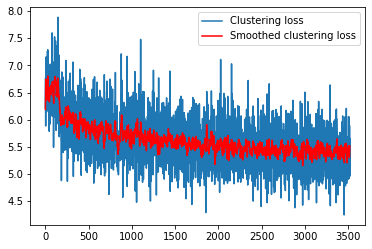

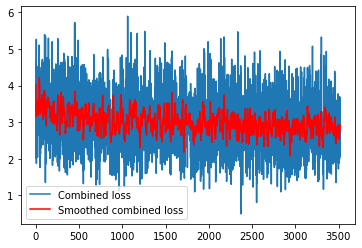

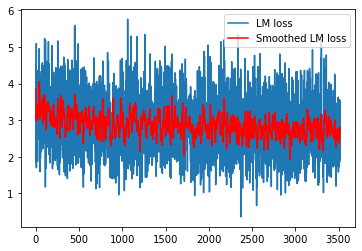

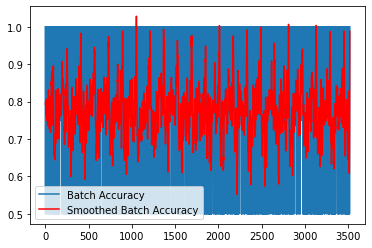

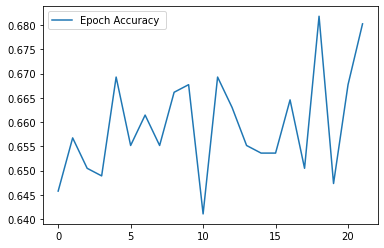

Epoch 22 (Alpha -44.06430017189175) | Batch: 159 | Combined Loss: 3.0380210876464844 | Clustering Loss: 5.933205604553223 | LM Loss 2.88969087600708 | Accuracy 1.0: : 160it [00:10, 14.97it/s]    


Cluster Accuarcy 0.6269592476489029


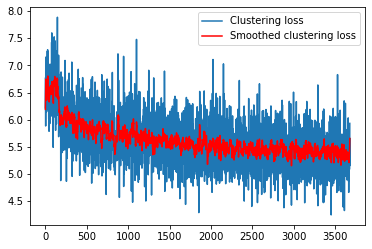

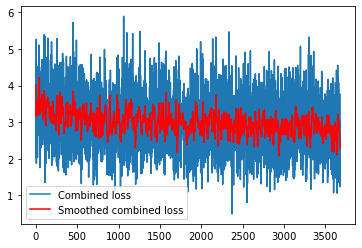

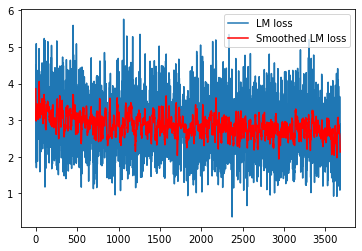

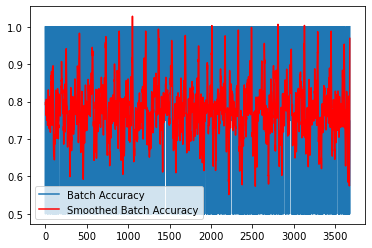

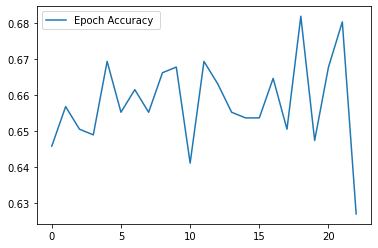

Epoch 23 (Alpha -47.19453918877458) | Batch: 159 | Combined Loss: 2.849909543991089 | Clustering Loss: 6.057389736175537 | LM Loss 2.698474884033203 | Accuracy 0.5: : 160it [00:11, 14.53it/s]    


Cluster Accuarcy 0.6692789968652038


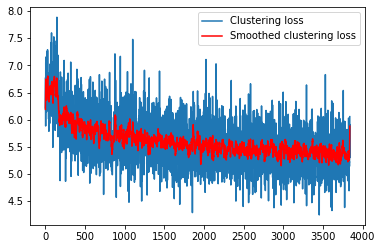

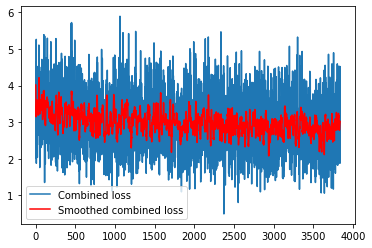

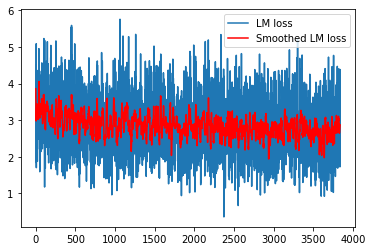

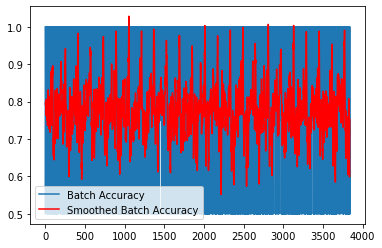

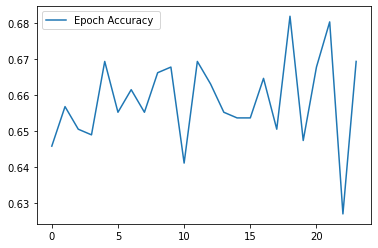

Epoch 24 (Alpha -50.45979035372043) | Batch: 159 | Combined Loss: 2.3982796669006348 | Clustering Loss: 5.60744047164917 | LM Loss 2.2580935955047607 | Accuracy 1.0: : 160it [00:11, 13.89it/s]  


Cluster Accuarcy 0.6410658307210031


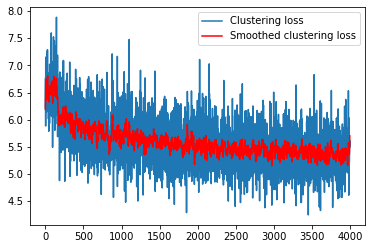

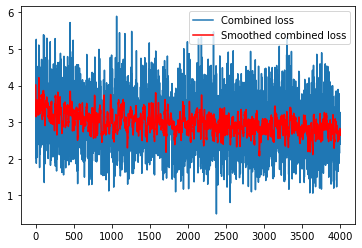

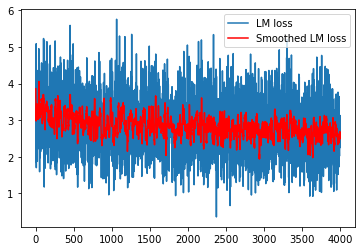

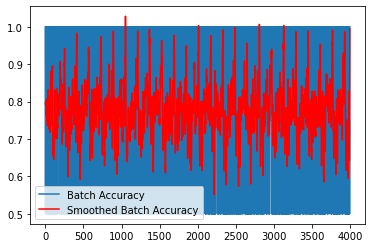

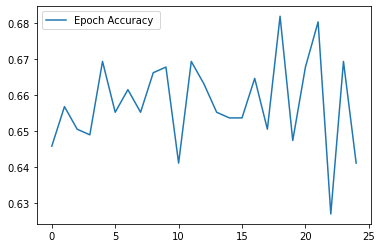

Epoch 25 (Alpha -53.86465117368467) | Batch: 128 | Combined Loss: 2.2009565830230713 | Clustering Loss: 5.5149993896484375 | LM Loss 2.0630815029144287 | Accuracy 0.75: : 128it [00:09, 14.26it/s]

In [ ]:
from scipy.signal import savgol_filter
from torch import nn

relu = nn.Tanh()

opt = torch.optim.AdamW(
    params=[centroids] + list(lm_model.parameters()),
    lr=5e-7, #2e-5, 5e-7
    eps=1e-8
)



lm_model.train()

comb_losses = []
clustering_losses = []
lm_losses = []
c_hist = []
emb_hist = []
batch_accs = []
epoch_accs = []

n_epochs = 500 #9
annealing_alpha = np.linspace(0.0, 2.5, n_epochs)
annealing_alpha = [1.5] * n_epochs
annealing_alpha = [10000.0] * n_epochs
#annealing_alpha = (np.arange(n_epochs)**2) / 10

initial_alpha = (2 ** (1/ (np.log(2)**2))) * 0.1
annealing_alpha = [initial_alpha]
for i in range(1, n_epochs + 1):
    
    annealing_alpha.append((2 ** (1/ (np.log(i+1)**2))) * annealing_alpha[i-1])


for epoch, alpha in zip(range(n_epochs), annealing_alpha):
    
    predicted_labels = []
    true_labels = []
    embs = []
    t = [] # improve this asap!
    

    c_hist.append(centroids.clone().detach().cpu().numpy())
    pbar = tqdm(enumerate(data_loader))
    for batch, batch_data in pbar:
        # lm part 
        texts, batch_labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        t.extend(texts)
        
        true_labels.extend(batch_labels)
        
        
        # clustering part
        input_ids = inputs['input_ids'].clone()
        input_ids, labels = mask_tokens(input_ids, tokenizer)
        inputs['input_ids'] = input_ids

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = lm_model(labels=labels, **inputs)
        lm_loss = outputs.loss
        
        
        texts, batch_labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        inputs.to(DEVICE)
        
        # 0. obtain embeddings for each input
        input_embeddings = lm_model.base_model(**inputs).last_hidden_state[:,0,:]
        #input_embeddings = lm_model.base_model(**inputs).last_hidden_state[:,1:,:].mean(dim=1)
        input_embeddings = input_embeddings.float()
        
        embs.append(input_embeddings.clone().cpu().detach().numpy())
        

        

        distances = torch.stack([lp_distance(embedding.unsqueeze(0), centroids.float()) for embedding in input_embeddings])
        nearest_centroids = torch.argmin(distances.cpu().clone().detach(), dim=1)
        distances = torch.transpose(distances, 0, 1)    

        # => shape (n_centroids, n_samples)
        # 2. compute the softmax for each centroid of each distance to each centroid per input sample
        # find min distances for each centroid
        min_distances = torch.min(distances, dim=1).values
        exponentials = torch.exp(- alpha * (distances - min_distances.unsqueeze(1)))
        softmax = exponentials / torch.sum(exponentials, dim=1).unsqueeze(1)

        # 3. weight the distanace between each sample and each centroid
        weighted_distances = distances * softmax

        # 4. sum over centroids to obtain loss
        opt.zero_grad()
        
        clustering_loss = weighted_distances.sum(dim=1).mean() 
        comb_loss = (lm_loss * 1.0) + (.025 * clustering_loss) # 1.0 | 0.025
        comb_loss.backward()
        
        torch.nn.utils.clip_grad_norm_([centroids] + list(lm_model.parameters()), 1.0)

        opt.step()

        accuracy = cluster_accuracy(batch_labels.numpy().astype('int'), nearest_centroids.numpy().astype('int'))[1]
        batch_accs.append(accuracy)
        predicted_labels.extend(nearest_centroids.numpy())
        clustering_losses.append(clustering_loss.item())
        lm_losses.append(lm_loss.item())
        comb_losses.append(comb_loss.item())
        
        pbar.set_description(f"Epoch {epoch} (Alpha -{alpha}) | Batch: {batch} | Combined Loss: {comb_loss.item()} | Clustering Loss: {clustering_loss.item()} | LM Loss {lm_loss.item()} | Accuracy {accuracy}")
        
    emb_hist.append(embs)
    
    matching, epoch_acc = cluster_accuracy(np.array(true_labels).astype('int'), np.array(predicted_labels))
    epoch_accs.append((matching, epoch_acc))
    print(f"Cluster Accuarcy {epoch_acc}")
    
    plt.plot(clustering_losses, label="Clustering loss")
    plt.plot(savgol_filter(clustering_losses, 21, 3), color='red', label="Smoothed clustering loss")
    plt.legend()
    plt.show()
    plt.plot(comb_losses, label="Combined loss")
    plt.plot(savgol_filter(comb_losses, 21, 3), color='red', label="Smoothed combined loss")
    plt.legend()
    plt.show()
    plt.plot(lm_losses, label="LM loss")
    plt.plot(savgol_filter(lm_losses, 21, 3), color='red', label="Smoothed LM loss")
    plt.legend()
    plt.show()
    plt.plot(batch_accs, label="Batch Accuracy")
    plt.plot(savgol_filter(batch_accs, 21, 3), color='red', label="Smoothed Batch Accuracy")
    plt.legend()
    plt.show()
    plt.plot([i[1] for i in epoch_accs], label="Epoch Accuracy ")
    plt.legend()
    plt.show()
    
    # eval part

In [ ]:
np_centroids = centroids.cpu().detach().numpy()
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels).astype('int')
true_labels.shape, predicted_labels.shape

embs = np.vstack(embs)

In [ ]:
print(cluster_accuracy(true_labels, predicted_labels)) # 0.6308411214953271 alpha [1.5]*n_epochs, random_state 42 kmeans++
print(normalized_mutual_info_score(true_labels, predicted_labels))
print(adjusted_rand_score(true_labels, predicted_labels))
print(silhouette_score(np.vstack(emb_hist[-1]), predicted_labels, metric="cosine"))

In [ ]:
np.unique(predicted_labels, return_counts=True)

In [ ]:
np.unique(true_labels, return_counts=True)

In [ ]:
np.unique(kmeans_cluster, return_counts=True)

In [ ]:
from umap import UMAP
from sklearn.decomposition import PCA
reducer = UMAP(n_components=2, n_neighbors=20)
reducer = PCA(n_components=2)
Xo = np.vstack([embs, np_centroids])
Xro = reducer.fit_transform(Xo)
labels_co = np.concatenate([predicted_labels, [f"Centroid {i}" for i in range(centroids.shape[0])]])
label_kmeans = np.concatenate([kmeans_cluster, [f"Centroid {i}" for i in range(centroids.shape[0])]])
labels_true = np.concatenate([true_labels, [f"Centroid {i}" for i in range(centroids.shape[0])]])

In [ ]:
t = [" ".join(i.split()) for i in t]

In [ ]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in labels_co], hover_name=t+["centroid"]*centroids.shape[0])
fig.show()

In [ ]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in labels_true], hover_name=t+["centroid"]*centroids.shape[0])
fig.show()

In [ ]:
(np.vstack(emb_hist[0]) == np.vstack(emb_hist[-1])).all()

In [ ]:
np.vstack(emb_hist[0]) == np.vstack(emb_hist[-1])

In [ ]:
print(* np.array(t)[np.array(predicted_labels) == 3], sep="\n"+"#"*100+"\n\n")

In [ ]:
np.unique(predicted_labels)

In [ ]:
np.unique(true_labels)

In [ ]:
np.vstack(emb_hist[-1])

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(true_labels).shape[0], n_init=20)

end_embeddings_kmeans_cluster = kmeans.fit_predict(np.vstack(emb_hist[-1]))

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

print(cluster_accuracy(true_labels, end_embeddings_kmeans_cluster)[1])
print(normalized_mutual_info_score(true_labels, end_embeddings_kmeans_cluster))
print(adjusted_rand_score(true_labels, end_embeddings_kmeans_cluster))

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(np.vstack(emb_hist[-1]), end_embeddings_kmeans_cluster, metric="euclidean")

In [ ]:
from sklearn.metrics import silhouette_score
for i in emb_hist:
    print(silhouette_score(np.vstack(i), predicted_labels, metric="cosine"))

In [ ]:
list(map(len, texts))

In [ ]:
lm_model.base_model(**inputs).last_hidden_state[:,:,:].max(dim=1).values.shape

In [ ]:
lm_model.base_model(**inputs).last_hidden_state[:,0,:].shape

In [ ]:
centroids

In [ ]:
initial_alpha = (2 ** (1/ (np.log(2)**2))) * 0.1
initial_alpha

In [ ]:
initial_alpha = (2 ** (1/ (np.log(2)**2))) * 0.1
annealing_alpha = [initial_alpha]
for i in range(1, 101):
    
    annealing_alpha.append((2 ** (1/ (np.log(i+1)**2))) * annealing_alpha[i-1])

In [ ]:
annealing_alpha

In [ ]:
2**(1/np.log(1))

In [ ]:
plt.plot()

In [ ]:
1 / ((np.log(np.arange(1, 100 +1)**2)) + 0.01)